In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet import MobileNet
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import argparse


%matplotlib inline

In [ ]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)

        img = cv2.imread(PATH)

        img = cv2.resize(img, (RESIZE,RESIZE))

        IMG.append(np.array(img))
    return IMG

In [ ]:
#load data
early_blight_norm_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Normal',224))
early_blight_serious_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Serious',224))
late_blight_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/LateBlight',224))
healthy_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Healthy',224))
insect_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Insect',224))
lrv_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/LeafRoll',224))
virus_train =np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Virus',224))

early_blight_norm_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Normal',224))
early_blight_serious_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Serious',224))
late_blight_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/LateBlight',224))
healthy_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Healthy',224))
insect_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Insect',224))
lrv_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/LeafRoll',224))
virus_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Virus',224))

100%|██████████| 200/200 [00:10<00:00, 19.04it/s]


In [ ]:
print(len(lrv_test))

44


In [ ]:
# Create labels
early_blight_norm_train_label = np.full(len(early_blight_norm_train),0)
early_blight_serious_train_label = np.full(len(early_blight_serious_train),1)
late_blight_train_label = np.full(len(late_blight_train),2)
healthy_train_label = np.full(len(healthy_train),3)
insect_train_label = np.full(len(insect_train),4)
lrv_train_label = np.full(len(lrv_train),5)
virus_train_label = np.full(len(virus_train),6)

early_blight_norm_test_label = np.full(len(early_blight_norm_test),0)
early_blight_serious_test_label = np.full(len(early_blight_serious_test),1)
late_blight_test_label = np.full(len(late_blight_test),2)
healthy_test_label = np.full(len(healthy_test),3)
insect_test_label = np.full(len(insect_test),4)
lrv_test_label = np.full(len(lrv_test),5)
virus_test_label = np.full(len(virus_test),6)

In [ ]:
# Merge data
X_train = np.concatenate((early_blight_norm_train, early_blight_serious_train, late_blight_train, healthy_train, insect_train, lrv_train, virus_train), axis = 0)
Y_train = np.concatenate((early_blight_norm_train_label, early_blight_serious_train_label, late_blight_train_label, healthy_train_label, insect_train_label, lrv_train_label, virus_train_label), axis = 0)
X_test = np.concatenate((early_blight_norm_test, early_blight_serious_test, late_blight_test, healthy_test, insect_test, lrv_test,  virus_test), axis = 0)
Y_test = np.concatenate((early_blight_norm_test_label, early_blight_serious_test_label, late_blight_test_label, healthy_test_label, insect_test_label, lrv_test_label, virus_test_label), axis = 0)

In [ ]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

In [ ]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 7)
Y_test = to_categorical(Y_test, num_classes= 7)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

In [ ]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.4,
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images

    )

In [ ]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)


resnet50   = ResNet50(include_top=False, input_shape=input_shape)(inputs)


94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(resnet50)])
outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(128,activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(7, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=0.0001, decay=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 concatenate (Concatenate)   (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                              

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Drive/ResNet50(7_classes).hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [16]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/50
124/123 [==============================] - ETA: 0s - loss: 0.6019 - accuracy: 0.6600

123/123 [==============================] - 112s 745ms/step - loss: 0.6019 - accuracy: 0.6600 - val_loss: 0.7091 - val_accuracy: 0.8818 - lr: 1.0000e-04
Epoch 2/50
124/123 [==============================] - ETA: 0s - loss: 0.3869 - accuracy: 0.8526

123/123 [==============================] - 74s 594ms/step - loss: 0.3869 - accuracy: 0.8526 - val_loss: 0.2811 - val_accuracy: 0.9475 - lr: 1.0000e-04
Epoch 3/50
124/123 [==============================] - ETA: 0s - loss: 0.3327 - accuracy: 0.8675

123/123 [==============================] - 76s 611ms/step - loss: 0.3327 - accuracy: 0.8675 - val_loss: 0.1998 - val_accuracy: 0.9667 - lr: 1.0000e-04
Epoch 4/50
124/123 [==============================] - ETA: 0s - loss: 0.3007 - accuracy: 0.8809

123/123 [==============================] - 75s 606ms/step - loss: 0.3007 - accuracy: 0.8809 - val_loss: 0.1742 - val_accuracy: 0.9838 - lr: 1.0000e-04
Epoch 5/50
124/123 [==============================] - ETA: 0s - loss: 0.2851 - accuracy: 0.8746

123/123 [==============================] - 75s 604ms/step - loss: 0.2851 - accuracy: 0.8746 - val_loss: 0.1630 - val_accuracy: 0.9697 - lr: 1.0000e-04
Epoch 6/50
124/123 [==============================] - ETA: 0s - loss: 0.2623 - accuracy: 0.8878

123/123 [==============================] - 74s 597ms/step - loss: 0.2623 - accuracy: 0.8878 - val_loss: 0.2932 - val_accuracy: 0.9111 - lr: 1.0000e-04
Epoch 7/50
124/123 [==============================] - ETA: 0s - loss: 0.2329 - accuracy: 0.8959

123/123 [==============================] - 71s 571ms/step - loss: 0.2329 - accuracy: 0.8959 - val_loss: 0.1169 - val_accuracy: 0.9788 - lr: 1.0000e-04
Epoch 8/50
124/123 [==============================] - ETA: 0s - loss: 0.2159 - accuracy: 0.9034

123/123 [==============================] - 71s 573ms/step - loss: 0.2159 - accuracy: 0.9034 - val_loss: 0.0914 - val_accuracy: 0.9788 - lr: 1.0000e-04
Epoch 9/50
124/123 [==============================] - ETA: 0s - loss: 0.2001 - accuracy: 0.9012

123/123 [==============================] - 75s 608ms/step - loss: 0.2001 - accuracy: 0.9012 - val_loss: 0.0973 - val_accuracy: 0.9758 - lr: 1.0000e-04
Epoch 10/50
124/123 [==============================] - ETA: 0s - loss: 0.1853 - accuracy: 0.9012

123/123 [==============================] - 73s 589ms/step - loss: 0.1853 - accuracy: 0.9012 - val_loss: 0.0788 - val_accuracy: 0.9879 - lr: 1.0000e-04
Epoch 11/50
124/123 [==============================] - ETA: 0s - loss: 0.1744 - accuracy: 0.9034

123/123 [==============================] - 73s 591ms/step - loss: 0.1744 - accuracy: 0.9034 - val_loss: 0.0736 - val_accuracy: 0.9788 - lr: 1.0000e-04
Epoch 12/50
124/123 [==============================] - ETA: 0s - loss: 0.1571 - accuracy: 0.9123

123/123 [==============================] - 74s 594ms/step - loss: 0.1571 - accuracy: 0.9123 - val_loss: 0.0673 - val_accuracy: 0.9798 - lr: 1.0000e-04
Epoch 13/50
124/123 [==============================] - ETA: 0s - loss: 0.1479 - accuracy: 0.9093

123/123 [==============================] - 74s 595ms/step - loss: 0.1479 - accuracy: 0.9093 - val_loss: 0.0577 - val_accuracy: 0.9798 - lr: 1.0000e-04
Epoch 14/50
124/123 [==============================] - ETA: 0s - loss: 0.1350 - accuracy: 0.9105

123/123 [==============================] - 73s 587ms/step - loss: 0.1350 - accuracy: 0.9105 - val_loss: 0.0592 - val_accuracy: 0.9768 - lr: 1.0000e-04
Epoch 15/50
124/123 [==============================] - ETA: 0s - loss: 0.1315 - accuracy: 0.9110

123/123 [==============================] - 73s 587ms/step - loss: 0.1315 - accuracy: 0.9110 - val_loss: 0.0417 - val_accuracy: 0.9869 - lr: 1.0000e-04
Epoch 16/50
124/123 [==============================] - ETA: 0s - loss: 0.1111 - accuracy: 0.9229

123/123 [==============================] - 75s 606ms/step - loss: 0.1111 - accuracy: 0.9229 - val_loss: 0.0511 - val_accuracy: 0.9677 - lr: 1.0000e-04
Epoch 17/50
124/123 [==============================] - ETA: 0s - loss: 0.1078 - accuracy: 0.9267

123/123 [==============================] - 73s 590ms/step - loss: 0.1078 - accuracy: 0.9267 - val_loss: 0.0318 - val_accuracy: 0.9909 - lr: 1.0000e-04
Epoch 18/50
124/123 [==============================] - ETA: 0s - loss: 0.0948 - accuracy: 0.9267

123/123 [==============================] - 71s 575ms/step - loss: 0.0948 - accuracy: 0.9267 - val_loss: 0.0343 - val_accuracy: 0.9778 - lr: 1.0000e-04
Epoch 19/50
124/123 [==============================] - ETA: 0s - loss: 0.1005 - accuracy: 0.9221

123/123 [==============================] - 74s 596ms/step - loss: 0.1005 - accuracy: 0.9221 - val_loss: 0.0365 - val_accuracy: 0.9667 - lr: 1.0000e-04
Epoch 20/50
124/123 [==============================] - ETA: 0s - loss: 0.0902 - accuracy: 0.9257

123/123 [==============================] - 75s 602ms/step - loss: 0.0902 - accuracy: 0.9257 - val_loss: 0.0277 - val_accuracy: 0.9818 - lr: 1.0000e-04
Epoch 21/50
124/123 [==============================] - ETA: 0s - loss: 0.0867 - accuracy: 0.9249

123/123 [==============================] - 76s 612ms/step - loss: 0.0867 - accuracy: 0.9249 - val_loss: 0.0251 - val_accuracy: 0.9828 - lr: 1.0000e-04
Epoch 22/50
124/123 [==============================] - ETA: 0s - loss: 0.0833 - accuracy: 0.9282

123/123 [==============================] - 72s 585ms/step - loss: 0.0833 - accuracy: 0.9282 - val_loss: 0.0289 - val_accuracy: 0.9818 - lr: 1.0000e-04
Epoch 23/50
124/123 [==============================] - ETA: 0s - loss: 0.0799 - accuracy: 0.9211

123/123 [==============================] - 74s 596ms/step - loss: 0.0799 - accuracy: 0.9211 - val_loss: 0.0353 - val_accuracy: 0.9677 - lr: 1.0000e-04
Epoch 24/50
124/123 [==============================] - ETA: 0s - loss: 0.0758 - accuracy: 0.9280

123/123 [==============================] - 75s 601ms/step - loss: 0.0758 - accuracy: 0.9280 - val_loss: 0.0193 - val_accuracy: 0.9818 - lr: 1.0000e-04
Epoch 25/50
124/123 [==============================] - ETA: 0s - loss: 0.0725 - accuracy: 0.9305

123/123 [==============================] - 75s 605ms/step - loss: 0.0725 - accuracy: 0.9305 - val_loss: 0.0227 - val_accuracy: 0.9818 - lr: 1.0000e-04
Epoch 26/50
124/123 [==============================] - ETA: 0s - loss: 0.0630 - accuracy: 0.9403

123/123 [==============================] - 75s 602ms/step - loss: 0.0630 - accuracy: 0.9403 - val_loss: 0.0273 - val_accuracy: 0.9838 - lr: 1.0000e-04
Epoch 27/50
124/123 [==============================] - ETA: 0s - loss: 0.0699 - accuracy: 0.9300

123/123 [==============================] - 74s 601ms/step - loss: 0.0699 - accuracy: 0.9300 - val_loss: 0.0223 - val_accuracy: 0.9889 - lr: 1.0000e-04
Epoch 28/50
124/123 [==============================] - ETA: 0s - loss: 0.0702 - accuracy: 0.9292

123/123 [==============================] - 72s 580ms/step - loss: 0.0702 - accuracy: 0.9292 - val_loss: 0.0199 - val_accuracy: 0.9808 - lr: 1.0000e-04
Epoch 29/50
124/123 [==============================] - ETA: 0s - loss: 0.0662 - accuracy: 0.9292

123/123 [==============================] - 73s 593ms/step - loss: 0.0662 - accuracy: 0.9292 - val_loss: 0.0231 - val_accuracy: 0.9737 - lr: 1.0000e-04
Epoch 30/50
124/123 [==============================] - ETA: 0s - loss: 0.0589 - accuracy: 0.9403

123/123 [==============================] - 72s 579ms/step - loss: 0.0589 - accuracy: 0.9403 - val_loss: 0.0158 - val_accuracy: 0.9848 - lr: 1.0000e-04
Epoch 31/50
124/123 [==============================] - ETA: 0s - loss: 0.0572 - accuracy: 0.9406

123/123 [==============================] - 73s 589ms/step - loss: 0.0572 - accuracy: 0.9406 - val_loss: 0.0144 - val_accuracy: 0.9838 - lr: 1.0000e-04
Epoch 32/50
124/123 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.9338

123/123 [==============================] - 71s 576ms/step - loss: 0.0603 - accuracy: 0.9338 - val_loss: 0.0200 - val_accuracy: 0.9788 - lr: 1.0000e-04
Epoch 33/50
124/123 [==============================] - ETA: 0s - loss: 0.0533 - accuracy: 0.9408

123/123 [==============================] - 72s 578ms/step - loss: 0.0533 - accuracy: 0.9408 - val_loss: 0.0130 - val_accuracy: 0.9889 - lr: 1.0000e-04
Epoch 34/50
124/123 [==============================] - ETA: 0s - loss: 0.0539 - accuracy: 0.9401

123/123 [==============================] - 72s 579ms/step - loss: 0.0539 - accuracy: 0.9401 - val_loss: 0.0148 - val_accuracy: 0.9879 - lr: 1.0000e-04
Epoch 35/50
124/123 [==============================] - ETA: 0s - loss: 0.0543 - accuracy: 0.9383

123/123 [==============================] - 73s 586ms/step - loss: 0.0543 - accuracy: 0.9383 - val_loss: 0.0142 - val_accuracy: 0.9859 - lr: 1.0000e-04
Epoch 36/50
124/123 [==============================] - ETA: 0s - loss: 0.0507 - accuracy: 0.9446

123/123 [==============================] - 76s 608ms/step - loss: 0.0507 - accuracy: 0.9446 - val_loss: 0.0281 - val_accuracy: 0.9727 - lr: 1.0000e-04
Epoch 37/50
124/123 [==============================] - ETA: 0s - loss: 0.0470 - accuracy: 0.9467

123/123 [==============================] - 73s 593ms/step - loss: 0.0470 - accuracy: 0.9467 - val_loss: 0.0362 - val_accuracy: 0.9434 - lr: 1.0000e-04
Epoch 38/50
124/123 [==============================] - ETA: 0s - loss: 0.0502 - accuracy: 0.9424

123/123 [==============================] - 72s 579ms/step - loss: 0.0502 - accuracy: 0.9424 - val_loss: 0.0248 - val_accuracy: 0.9818 - lr: 1.0000e-04
Epoch 39/50
124/123 [==============================] - ETA: 0s - loss: 0.0482 - accuracy: 0.9467

123/123 [==============================] - 75s 608ms/step - loss: 0.0482 - accuracy: 0.9467 - val_loss: 0.0140 - val_accuracy: 0.9879 - lr: 1.0000e-04
Epoch 40/50
124/123 [==============================] - ETA: 0s - loss: 0.0465 - accuracy: 0.9444

123/123 [==============================] - 73s 584ms/step - loss: 0.0465 - accuracy: 0.9444 - val_loss: 0.0140 - val_accuracy: 0.9828 - lr: 1.0000e-04
Epoch 41/50
124/123 [==============================] - ETA: 0s - loss: 0.0512 - accuracy: 0.9391

123/123 [==============================] - 73s 588ms/step - loss: 0.0512 - accuracy: 0.9391 - val_loss: 0.3281 - val_accuracy: 0.9172 - lr: 1.0000e-04
Epoch 42/50
124/123 [==============================] - ETA: 0s - loss: 0.0504 - accuracy: 0.9401

123/123 [==============================] - 73s 589ms/step - loss: 0.0504 - accuracy: 0.9401 - val_loss: 0.0115 - val_accuracy: 0.9879 - lr: 1.0000e-04
Epoch 43/50
124/123 [==============================] - ETA: 0s - loss: 0.0430 - accuracy: 0.9512

123/123 [==============================] - 75s 609ms/step - loss: 0.0430 - accuracy: 0.9512 - val_loss: 0.0120 - val_accuracy: 0.9879 - lr: 1.0000e-04
Epoch 44/50
124/123 [==============================] - ETA: 0s - loss: 0.0480 - accuracy: 0.9421

123/123 [==============================] - 73s 590ms/step - loss: 0.0480 - accuracy: 0.9421 - val_loss: 0.0223 - val_accuracy: 0.9758 - lr: 1.0000e-04
Epoch 45/50
124/123 [==============================] - ETA: 0s - loss: 0.0464 - accuracy: 0.9512

123/123 [==============================] - 73s 589ms/step - loss: 0.0464 - accuracy: 0.9512 - val_loss: 0.0187 - val_accuracy: 0.9808 - lr: 1.0000e-04
Epoch 46/50
124/123 [==============================] - ETA: 0s - loss: 0.0421 - accuracy: 0.9479

123/123 [==============================] - 75s 607ms/step - loss: 0.0421 - accuracy: 0.9479 - val_loss: 0.0141 - val_accuracy: 0.9848 - lr: 1.0000e-04
Epoch 47/50
124/123 [==============================] - ETA: 0s - loss: 0.0418 - accuracy: 0.9494

123/123 [==============================] - 74s 596ms/step - loss: 0.0418 - accuracy: 0.9494 - val_loss: 0.0154 - val_accuracy: 0.9848 - lr: 1.0000e-04
Epoch 48/50
124/123 [==============================] - ETA: 0s - loss: 0.0432 - accuracy: 0.9484

123/123 [==============================] - 76s 612ms/step - loss: 0.0432 - accuracy: 0.9484 - val_loss: 0.0169 - val_accuracy: 0.9808 - lr: 1.0000e-04
Epoch 49/50
124/123 [==============================] - ETA: 0s - loss: 0.0435 - accuracy: 0.9472

123/123 [==============================] - 73s 590ms/step - loss: 0.0435 - accuracy: 0.9472 - val_loss: 0.0352 - val_accuracy: 0.9576 - lr: 1.0000e-04
Epoch 50/50
124/123 [==============================] - ETA: 0s - loss: 0.0466 - accuracy: 0.9446

123/123 [==============================] - 72s 580ms/step - loss: 0.0466 - accuracy: 0.9446 - val_loss: 0.0123 - val_accuracy: 0.9889 - lr: 1.0000e-04


42/42 [==============================] - 6s 130ms/step
Confusion matrix, without normalization
[[202   0   0   4   0   0   0]
 [  0 278   0   0   0   0   0]
 [  0   0 200   0   0   0   0]
 [  0   0   0 205   0   0   0]
 [  0   0   0   0 186  16   4]
 [  0   1   0   0   0  43   0]
 [  0   0   0   0   4   0 196]]


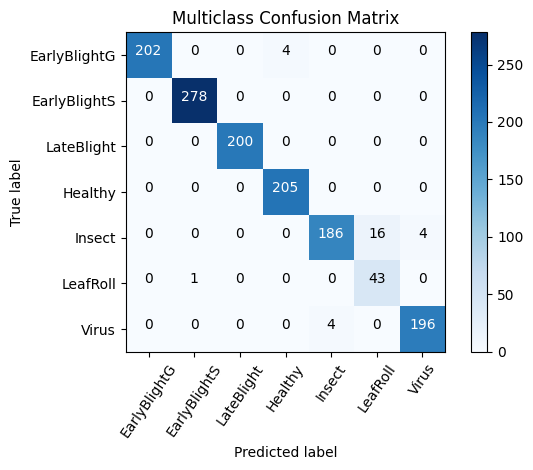

In [17]:
Y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['EarlyBlightG','EarlyBlightS', 'LateBlight', 'Healthy', 'Insect','LeafRoll', 'Virus']
plot_confusion_matrix(cm, cm_plot_label, title ='Multiclass Confusion Matrix')

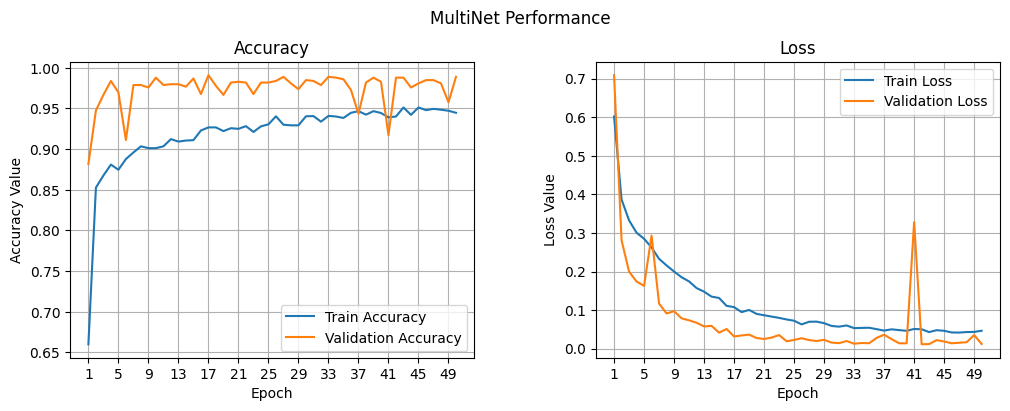

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('MultiNet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,51))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 51, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 51, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [19]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['EarlyBlight General','EarlyBlight Serious', 'LateBlight', 'Healthy', 'Insect','LeafRoll', 'Virus']
print(classification_report(y_test, Y_pred, target_names=target_names))

42/42 [==============================] - 4s 86ms/step
Classification Report
                     precision    recall  f1-score   support

EarlyBlight General       1.00      0.98      0.99       206
EarlyBlight Serious       1.00      1.00      1.00       278
         LateBlight       1.00      1.00      1.00       200
            Healthy       0.98      1.00      0.99       205
             Insect       0.98      0.90      0.94       206
           LeafRoll       0.73      0.98      0.83        44
              Virus       0.98      0.98      0.98       200

           accuracy                           0.98      1339
          macro avg       0.95      0.98      0.96      1339
       weighted avg       0.98      0.98      0.98      1339



In [20]:
pred=model.predict(X_test)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
    precision_score,
    recall_score,
    mean_squared_error,
    mean_absolute_error
)

Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)

accuray = accuracy_score(Y_pred, y_test)
f1 = f1_score(Y_pred, y_test, average="weighted")
precision = precision_score(Y_pred, y_test, average='weighted')
recall = recall_score(Y_pred, y_test, average='weighted')
mse = mean_squared_error(Y_pred, y_test)
mae = mean_absolute_error(Y_pred, y_test)

print("ResNet50")
print("Accuracy:", accuray)
print("F1 Score:", f1)
print("precision:", precision)
print("recall:", recall)
print("MSE:", mse)
print("MAE:", mae)

42/42 [==============================] - 4s 86ms/step
ResNet50
Accuracy: 0.9783420463032113
F1 Score: 0.9777792165143765
precision: 0.9793055704781598
recall: 0.9783420463032113
MSE: 0.07468259895444361
MAE: 0.035847647498132934
